In [4]:
from sklearn import svm
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split



In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.base import clone


In [2]:
# Load the training and test datasets
training_data = pd.read_csv('fraudTrain.csv')
test_data = pd.read_csv('fraudTest.csv')

# Define columns to drop (added 'first' and 'last' from your categorical cols)
drop_columns = ['Unnamed: 0', 'trans_num', 'dob', 'unix_time']

# Drop unnecessary columns from both datasets
training_data = training_data.drop(columns=[col for col in drop_columns if col in training_data.columns])
test_data = test_data.drop(columns=[col for col in drop_columns if col in test_data.columns])

# Handle missing values in numeric columns using training data medians
numeric_cols = training_data.select_dtypes(include=['float64', 'int64']).columns
medians = training_data[numeric_cols].median()
training_data[numeric_cols] = training_data[numeric_cols].fillna(medians)
test_data[numeric_cols] = test_data[numeric_cols].fillna(medians)

# Define categorical columns to encode
categorical_cols = ['merchant', 'category', 'gender', 'state', 'job', 'street', 'city', 'first', 'last']

frequency_mappings = {}
for col in categorical_cols:
    print(f"\n===== Processing column: {col} =====")
    
    # Fill missing values with 'unknown'
    training_data[col] = training_data[col].fillna('unknown')
    test_data[col] = test_data[col].fillna('unknown')
    
    # --- Frequency calculation (ONLY on training data) ---
    freq = training_data[col].value_counts()
    freq_order = freq.index
    
    print("\nTop 5 most frequent categories in TRAINING data:")
    print(freq.head())
    
    # Create mapping: {category -> rank} (0 = most frequent)
    mapping = {cat: i for i, cat in enumerate(freq_order)}
    
    # --- Apply to training data ---
    training_data[col] = training_data[col].map(mapping)
    
    # Check encoding in training data
    print("\nTraining data value counts after encoding:")
    print(training_data[col].value_counts().head())
    
    # Store mapping for test data
    frequency_mappings[col] = mapping
    
    # --- Apply to test data ---
    test_data[col] = test_data[col].map(mapping).fillna(-1).astype(int)
    
    # --- Verify no contamination from test data ---
    test_unique = set(test_data[col].unique())
    train_unique = set(training_data[col].unique())
    unseen_in_test = test_unique - train_unique
    
    print(f"\nTest data contains {len(unseen_in_test)} unseen categories (encoded as -1)")
    if unseen_in_test:
        print(f"Example unseen categories in test: {list(unseen_in_test)[:3]}...")
    
    # Check distribution in test data
    print("\nTest data value counts after encoding:")
    print(test_data[col].value_counts().head())
    
    print(f"\n✔ Completed column: {col}")

# Convert and process transaction datetime only
def process_dates(df):
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
    df['transaction_day'] = df['trans_date_trans_time'].dt.day
    df['transaction_month'] = df['trans_date_trans_time'].dt.month
    df['transaction_weekday'] = df['trans_date_trans_time'].dt.weekday
    df['transaction_year'] = df['trans_date_trans_time'].dt.year
    return df.drop(columns=['trans_date_trans_time'])

# Process both datasets
training_data = process_dates(training_data)
test_data = process_dates(test_data)

# Handle potential missing values in datetime features
datetime_features = [
    'transaction_hour', 'transaction_day', 
    'transaction_month', 'transaction_weekday', 'transaction_year'
]

training_data[datetime_features] = training_data[datetime_features].fillna(-1)
test_data[datetime_features] = test_data[datetime_features].fillna(-1)

# Final verification
print("\nFinal Data Shapes:")
print(f"Training data: {training_data.shape}")
print(f"Test data: {test_data.shape}")
print("\nTraining data columns:", training_data.columns.tolist())
print("\nMissing values check:")
print("Training:", training_data.isnull().sum().sum())
print("Test:", test_data.isnull().sum().sum())


===== Processing column: merchant =====

Top 5 most frequent categories in TRAINING data:
merchant
fraud_Kilback LLC    4403
fraud_Cormier LLC    3649
fraud_Schumm PLC     3634
fraud_Kuhn LLC       3510
fraud_Boyer PLC      3493
Name: count, dtype: int64

Training data value counts after encoding:
merchant
0    4403
1    3649
2    3634
3    3510
4    3493
Name: count, dtype: int64

Test data contains 0 unseen categories (encoded as -1)

Test data value counts after encoding:
merchant
0    1859
1    1597
2    1561
3    1521
5    1519
Name: count, dtype: int64

✔ Completed column: merchant

===== Processing column: category =====

Top 5 most frequent categories in TRAINING data:
category
gas_transport    131659
grocery_pos      123638
home             123115
shopping_pos     116672
kids_pets        113035
Name: count, dtype: int64

Training data value counts after encoding:
category
0    131659
1    123638
2    123115
3    116672
4    113035
Name: count, dtype: int64

Test data contains

In [ ]:
# Split data into features and target
X = training_data.drop(columns=['is_fraud'])  # All columns except is_fraud
Y = training_data['is_fraud']  # Target column

# Split into 80% training and 20% validation
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define and train the model
linear_classifier = make_pipeline(
    StandardScaler(),                         # Scale features
    svm.LinearSVC(penalty="l2", C=0.5)        # Linear SVM
)

linear_classifier.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=0.5))])

In [205]:
X_test = test_data.drop(columns=['is_fraud'])
y_test = np.array(test_data['is_fraud'])
predictions = linear_classifier.predict(X_test)

print(confusion_matrix(y_test, predictions))


[[553509     65]
 [  2145      0]]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

In [225]:
X_train = training_data.drop(columns=['is_fraud'])
y_train = training_data['is_fraud']
X_test = test_data.drop(columns=['is_fraud'])
y_test = test_data['is_fraud']

Computed optimal decision threshold using validation data:
Optimal Threshold: 1.2291 with Utility: -65990


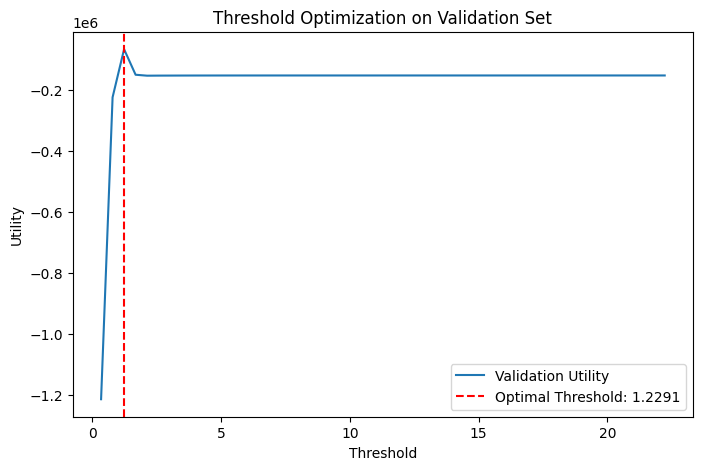


Detailed evaluation on test data:
Optimal Threshold: 1.23

=== Confusion Matrix ===
True Positives (TP): 632 (Correct fraud detections)
False Positives (FP): 1664 (Legitimate transactions flagged)
True Negatives (TN): 551910 (Correctly ignored legitimate)
False Negatives (FN): 1513 (Missed fraud cases)

=== Financial Impact ===
Fraud Prevention Savings: $31600
Missed Fraud Costs: $151300
False Alarm Penalties: $8320

Total Utility: $-128020

=== Performance Metrics ===
Precision: 27.53%
Recall (Detection Rate): 29.46%
False Positive Rate: 0.30%


In [6]:

# Split training_data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(
    training_data.drop(columns=['is_fraud']),
    training_data['is_fraud'],
    test_size=0.2,
    random_state=42
)

# Define test set from test_data
X_test = test_data.drop(columns=['is_fraud'])
y_test = test_data['is_fraud']

# ----- Compute Class Weights -----
classes = np.array([0, 1])  # 0=legitimate, 1=fraud
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=training_data['is_fraud']
)

cost_ratio = 20  # Extra cost weight for fraud cases

# Final class weights incorporating both imbalance and cost considerations
final_class_weights = {
    0: class_weights[0],
    1: class_weights[1] * cost_ratio
}

# ----- Define and Train the Model -----
# Build an optimized Linear SVM pipeline with hyperparameter tuning
svm_pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(
        penalty='l2',
        class_weight=final_class_weights,
        dual=False,          # Better for large datasets
        max_iter=10000,
        random_state=42
    )
)

# Train the model on the training set (X_train, y_train)
svm_pipeline.fit(X_train, y_train)

# ----- Utility Function for Evaluation -----
def calculate_utility_vectorized(y_true, pred_matrix):
    """
    Calculate utility for all thresholds simultaneously using matrix operations.
    Utility = (TP * 50) - (FN * 100) - (FP * 5)
    """
    # Convert y_true to numpy array if needed
    y_true = y_true.values if isinstance(y_true, pd.Series) else y_true
    y_true_2d = y_true.reshape(1, -1)  # Shape (1, n_samples)
    
    # Calculate confusion matrix components for all thresholds
    tp = np.sum((pred_matrix == 1) & (y_true_2d == 1), axis=1)
    fp = np.sum((pred_matrix == 1) & (y_true_2d == 0), axis=1)
    fn = np.sum((pred_matrix == 0) & (y_true_2d == 1), axis=1)
    
    return tp * 50 - fn * 100 - fp * 5

def detailed_evaluation(y_true, y_pred, threshold):
    """
    Enhanced evaluation that prints confusion matrix details,
    financial impact, and performance metrics.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    utility = (tp * 50) - (fn * 100) - (fp * 5)
    
    print(f"Optimal Threshold: {threshold:.2f}")
    print("\n=== Confusion Matrix ===")
    print(f"True Positives (TP): {tp} (Correct fraud detections)")
    print(f"False Positives (FP): {fp} (Legitimate transactions flagged)")
    print(f"True Negatives (TN): {tn} (Correctly ignored legitimate)")
    print(f"False Negatives (FN): {fn} (Missed fraud cases)")
    
    print("\n=== Financial Impact ===")
    print(f"Fraud Prevention Savings: ${tp * 50}")
    print(f"Missed Fraud Costs: ${fn * 100}")
    print(f"False Alarm Penalties: ${fp * 5}")
    print(f"\nTotal Utility: ${utility}")
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    print("\n=== Performance Metrics ===")
    print(f"Precision: {precision:.2%}")
    print(f"Recall (Detection Rate): {recall:.2%}")
    print(f"False Positive Rate: {fp/(fp+tn):.2%}")

# ----- Determine Optimal Threshold using the Validation Set -----
# Get decision function scores on the validation set
val_decision_values = svm_pipeline.decision_function(X_val)

# Generate a range of thresholds to test; adjust range as needed
thresholds = np.linspace(val_decision_values.min(), val_decision_values.max(), 50).reshape(-1, 1)
val_decision_values_2d = val_decision_values.reshape(1, -1)  # Shape (1, n_samples)

# Create prediction matrix for all thresholds (n_thresholds x n_samples)
pred_matrix_val = (val_decision_values_2d > thresholds).astype(int)

# Calculate utilities for each threshold using the validation set
utilities_val = calculate_utility_vectorized(y_val, pred_matrix_val)

# Find the best threshold based on maximum utility
best_idx = np.argmax(utilities_val)
best_threshold = thresholds[best_idx, 0]
best_utility = utilities_val[best_idx]

print("Computed optimal decision threshold using validation data:")
print(f"Optimal Threshold: {best_threshold:.4f} with Utility: {best_utility}")

# Optional: Visualize utility vs. threshold on validation data
plt.figure(figsize=(8, 5))
plt.plot(thresholds, utilities_val, label='Validation Utility')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {best_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Utility')
plt.title('Threshold Optimization on Validation Set')
plt.legend()
plt.show()

# ----- Evaluate on Test Data Using the Optimal Threshold -----
# Get decision function scores on the test set
test_decision_values = svm_pipeline.decision_function(X_test)
final_predictions = (test_decision_values > best_threshold).astype(int)

# Perform detailed evaluation on the test data
print("\nDetailed evaluation on test data:")
detailed_evaluation(y_test, final_predictions, best_threshold)


Seed 42: Best utility on validation = -65990, Threshold = 1.2291
Seed 43: Best utility on validation = -57340, Threshold = 1.1820
Seed 44: Best utility on validation = -53820, Threshold = 1.1586
Seed 45: Best utility on validation = -38385, Threshold = 1.0777
Seed 46: Best utility on validation = -63180, Threshold = 1.2062
Seed 47: Best utility on validation = -58050, Threshold = 1.1937
Seed 48: Best utility on validation = -52160, Threshold = 1.1692
Seed 49: Best utility on validation = -42465, Threshold = 1.1314
Seed 50: Best utility on validation = -49750, Threshold = 1.1553
Seed 51: Best utility on validation = -69350, Threshold = 1.2330
Seed 52: Best utility on validation = -55875, Threshold = 1.1655
Seed 53: Best utility on validation = -30230, Threshold = 1.0236
Seed 54: Best utility on validation = -31670, Threshold = 1.0481
Seed 55: Best utility on validation = -31150, Threshold = 1.0131
Seed 56: Best utility on validation = -39215, Threshold = 1.0558
Seed 57: Best utility on 

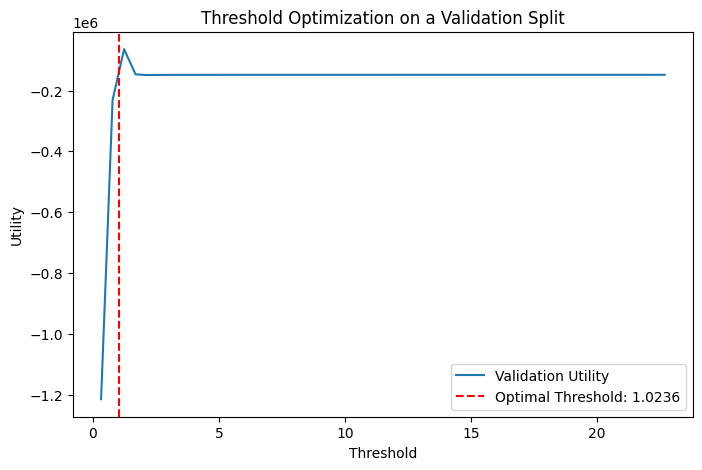

In [9]:

# ----- Prepare Data -----
# Assume training_data and test_data are already defined as pandas DataFrames.
# training_data has the 'is_fraud' column and so does test_data.

# Features and target for the full training dataset.
X_full = training_data.drop(columns=['is_fraud'])
y_full = training_data['is_fraud']

# Define test set from test_data.
X_test = test_data.drop(columns=['is_fraud'])
y_test = test_data['is_fraud']

# ----- Compute Class Weights -----
classes = np.array([0, 1])  # 0=legitimate, 1=fraud
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_full
)
cost_ratio = 20  # Additional cost factor for fraud cases

# Final class weights incorporating imbalance and cost considerations.
final_class_weights = {
    0: class_weights[0],
    1: class_weights[1] * cost_ratio
}

# ----- Define Utility and Evaluation Functions -----
def calculate_utility_vectorized(y_true, pred_matrix):
    """
    Calculate utility for all thresholds simultaneously using matrix operations.
    Utility = (TP * 50) - (FN * 100) - (FP * 5)
    """
    # Ensure y_true is a numpy array
    y_true = y_true.values if isinstance(y_true, pd.Series) else y_true
    y_true_2d = y_true.reshape(1, -1)  # Shape (1, n_samples)
    
    tp = np.sum((pred_matrix == 1) & (y_true_2d == 1), axis=1)
    fp = np.sum((pred_matrix == 1) & (y_true_2d == 0), axis=1)
    fn = np.sum((pred_matrix == 0) & (y_true_2d == 1), axis=1)
    
    return tp * 50 - fn * 100 - fp * 5

def detailed_evaluation(y_true, y_pred, threshold):
    """
    Enhanced evaluation printing confusion matrix details,
    financial impact, and performance metrics.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    utility = (tp * 50) - (fn * 100) - (fp * 5)
    
    print(f"Optimal Threshold: {threshold:.2f}")
    print("\n=== Confusion Matrix ===")
    print(f"True Positives (TP): {tp} (Correct fraud detections)")
    print(f"False Positives (FP): {fp} (Legitimate transactions flagged)")
    print(f"True Negatives (TN): {tn} (Correctly ignored legitimate)")
    print(f"False Negatives (FN): {fn} (Missed fraud cases)")
    
    print("\n=== Financial Impact ===")
    print(f"Fraud Prevention Savings: ${tp * 50}")
    print(f"Missed Fraud Costs: ${fn * 100}")
    print(f"False Alarm Penalties: ${fp * 5}")
    print(f"\nTotal Utility: ${utility}")
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    print("\n=== Performance Metrics ===")
    print(f"Precision: {precision:.2%}")
    print(f"Recall (Detection Rate): {recall:.2%}")
    print(f"False Positive Rate: {fp/(fp+tn):.2%}")

# ----- Define Base Model Pipeline -----
base_svm_pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(
        penalty='l2',
        class_weight=final_class_weights,
        dual=False,          # Better for large datasets
        max_iter=10000,
        random_state=42
    )
)

# ----- Repeated 80/20 Splits for Model Selection -----
num_splits = 5  # Number of distinct splits to try
best_val_utility = -np.inf
best_model = None
best_threshold = None

for seed in range(42, 62):
    # Create an 80/20 split for this iteration.
    X_train, X_val, y_train, y_val = train_test_split(
        X_full, y_full, test_size=0.2, random_state=seed
    )
    
    # Clone the base model and train on the current training split.
    model = clone(base_svm_pipeline)
    model.fit(X_train, y_train)
    
    # Get decision function scores on the validation set.
    val_scores = model.decision_function(X_val)
    
    # Generate a range of thresholds (you can adjust the range as needed).
    thresholds = np.linspace(val_scores.min(), val_scores.max(), 50).reshape(-1, 1)
    val_scores_2d = val_scores.reshape(1, -1)
    
    # Create prediction matrix for all thresholds (shape: n_thresholds x n_samples).
    pred_matrix_val = (val_scores_2d > thresholds).astype(int)
    
    # Calculate utilities for each threshold on the validation set.
    utilities_val = calculate_utility_vectorized(y_val, pred_matrix_val)
    
    # Select the threshold that gives the best utility for this split.
    best_idx_fold = np.argmax(utilities_val)
    fold_threshold = thresholds[best_idx_fold, 0]
    fold_utility = utilities_val[best_idx_fold]
    
    print(f"Seed {seed}: Best utility on validation = {fold_utility}, Threshold = {fold_threshold:.4f}")
    
    # Update best model if this fold's utility is the highest so far.
    if fold_utility > best_val_utility:
        best_val_utility = fold_utility
        best_model = model
        best_threshold = fold_threshold

print("\nBest model selected based on validation utility:")
print(f"Validation utility: {best_val_utility}")
print(f"Optimal threshold from validation: {best_threshold:.4f}")

# ----- Evaluate the Selected Model on Test Data -----
test_scores = best_model.decision_function(X_test)
final_predictions = (test_scores > best_threshold).astype(int)

print("\nDetailed evaluation on test data using the best model:")
detailed_evaluation(y_test, final_predictions, best_threshold)

# Optional: Visualize the utility vs. threshold for the best split (for illustration)
# (This visualization uses the last computed utility from the best split.)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, utilities_val, label='Validation Utility')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {best_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Utility')
plt.title('Threshold Optimization on a Validation Split')
plt.legend()
plt.show()
